In [1]:
using SparseArrays
using LinearAlgebra
using NLopt
using KrylovKit
using Statistics
using FiniteDifferences
using Revise
using TopologyOptimizationHelper

In [2]:
using PyPlot
using DelimitedFiles

In [147]:
function inv_LDOS_Optimize(L, ε, ω, b; dpml=0.5, resolution=20, Rpml=1e-20, ftol=1e-4, max_eval=500, design_width=L, fixed_width=0)
    A, x = Maxwell1d(L, ε, ω; dpml, resolution, Rpml)
    D² = A + spdiagm(ω^2 .* ε)
    M = length(x)
    inv_LDOS_vals = Float64[]
    inv_omegas = ComplexF64[]
    
    function inv_LDOS_obj(ε, grad)
        A = D² - spdiagm(ω^2 .* ε)
        LDOS, ∇LDOS = ∇_ε_LDOS(A, ω, b)
        grad .= ∇LDOS
        push!(inv_LDOS_vals, LDOS)

        A_now, _ = Maxwell1d(L, ε, ω; resolution, dpml, Rpml)
        ω₀_now = sqrt(Arnoldi_eig(A_now, ε, ω, b)[1])
        push!(inv_omegas, ω₀_now)
        
        return LDOS
    end

    design_indices = (-design_width/2 .< x .- mean(x) .< design_width/2) .& .!(-fixed_width/2 .< x .- mean(x) .< fixed_width/2)
    ub = copy(ε)
    lb = copy(ε)
    ub[design_indices] .= 12
    lb[design_indices] .= 1
    opt = Opt(:LD_CCSAQ, M)
    opt.lower_bounds = lb
    opt.upper_bounds = ub
    opt.ftol_rel = ftol
    opt.maxeval = max_eval
    opt.max_objective = inv_LDOS_obj

    (inv_LDOS_opt, inv_ε_opt, ret) = optimize(opt, ε)
    A_opt, _ = Maxwell1d(L, inv_ε_opt, ω; resolution, dpml, Rpml)
    ω₀_opt = sqrt(Arnoldi_eig(A_opt, inv_ε_opt, ω, b)[1])
    Q_opt = -real(ω₀_opt) / 2imag(ω₀_opt)

    @show numevals = opt.numevals # the number of function evaluations
    @show ω₀_opt
    @show Q_opt
    
    return inv_LDOS_opt, inv_ε_opt, inv_LDOS_vals, inv_omegas, x
end

inv_LDOS_Optimize (generic function with 1 method)

In [148]:
function mod_inv_LDOS_Optimize(L, ε, ω, b, x₀; dpml=0.5, resolution=20, Rpml=1e-20, ftol=1e-4, max_eval=500, ω_pml=ω, design_width=L)
    A, x = Maxwell1d(L, ε, ω; dpml, resolution, Rpml)
    D² = A + ω^2 .* spdiagm(ε)
    M = length(x)
    inv_LDOS_vals = Float64[]
    inv_omegas = ComplexF64[]
    
    function mod_inv_LDOS_obj(ε, grad)
        E = spdiagm(ε)
        E⁻¹ = spdiagm(1 ./ ε)
        A = D² - real(ω)^2 .* E
        C = E⁻¹ * A
        LU = lu(C)
        vals, vecs, _ = eigsolve(z -> LU \ z, x₀, 1, :LM, Arnoldi())
        vals = sqrt.(1 ./ vals .+ ω^2)
        ω₀, u₀ = vals[1], vecs[1]
        A₀ = D² - real(ω₀)^2 .* E
        v = A₀ \ b
        w = conj.(v)
        LDOS = -imag(v' * b)
        inv_LDOS = 1 / LDOS^2

        if !isempty(grad) 
            ∂LDOS_∂ε = real(ω₀)^2 * imag.(v.^2)
            ∂LDOS_∂ω = -2real(ω₀) * imag(v' * E * w)
            ∂ω_∂ε = -ω₀ .* u₀.^2 ./ 2sum(u₀.^2 .* ε)
            ∇LDOS = ∂LDOS_∂ε .+  ∂LDOS_∂ω .* real.(∂ω_∂ε)

            grad .= -2∇LDOS / LDOS^3
        end

        push!(inv_LDOS_vals, inv_LDOS)
        push!(inv_omegas, ω₀)
        
        return inv_LDOS
    end

    function freq_constraint(ε, grad)
        ω₀, ∂ω_∂ε = Eigengradient(A, ε, ω, x₀)
        if !isempty(grad) 
            grad .= -real.(∂ω_∂ε)
        end

        return ω - real(ω₀)
    end

    design_indices = -design_width / 2 .< x .- mean(x) .< design_width / 2
    ub = ones(M)
    ub[design_indices] .= 12
    
    opt = Opt(:LD_CCSAQ, M)
    # opt.params["verbosity"] = 1
    opt.lower_bounds = 1
    opt.upper_bounds = ub
    opt.ftol_rel = ftol
    opt.maxeval = max_eval
    opt.min_objective = mod_inv_LDOS_obj
    # opt.initial_step = 1e-3
    #inequality_constraint!(opt, freq_constraint)


    (inv_LDOS_opt, inv_ε_opt, ret) = optimize(opt, ε)
    ω₀ = inv_omegas[end]
    Q = -real(ω₀) / 2imag(ω₀)

    @show numevals = opt.numevals # the number of function evaluations
    @show ω₀
    @show Q
    
    return inv_LDOS_opt, inv_ε_opt, inv_LDOS_vals, inv_omegas, x
end

mod_inv_LDOS_Optimize (generic function with 1 method)

In [149]:
L = 5
res = 50
ε = ones(res * (L+1))
M = length(ε) 
ω = 2π
_, x = Maxwell1d(L, ε, ω; resolution=res)

b = zeros(M)
b[M÷2] = 1;

In [150]:
custom_epsilon = Fabry_Perot_epsilon.(L, x; λ=1);

In [151]:
A, _ = Maxwell1d(L, custom_epsilon, ω; resolution=res)
ω₀ = sqrt(Arnoldi_eig(A, custom_epsilon, ω, b)[1])
@show Q_fp = -real(ω₀) / 2imag(ω₀)

Q_fp = -(real(ω₀)) / (2 * imag(ω₀)) = 3.9663413059790134e7


3.9663413059790134e7

In [152]:
ε_vac = ones(M)
A_vac, _ = Maxwell1d(L, ε_vac, ω; resolution=res)
u = A_vac \ b
@show LDOS_vac = -imag(u' * b)

LDOS_vac = -(imag(u' * b)) = 0.0015894422269321887


0.0015894422269321887

In [177]:
LDOS_init, ε_init, init_LDOS_vals, init_omegas, x = inv_LDOS_Optimize(L, ε, ω, b; resolution=res, ftol=0, max_eval=1000)

numevals = opt.numevals = 1000
ω₀_opt = 6.283181561164203 - 0.00016178384097876867im
Q_opt = 19418.4460053361


(11.226352042012127, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0015894422269321887, 0.0016083907502234757, 0.0018105515374050593, 0.0014885737486222837, 0.0030250626916708072, 0.0005602595939346139, 0.0023243971283789014, 0.00829984026246054, 0.0017093821912479478, 0.0006435485280975625  …  11.187277910017093, 11.205950011130614, 9.71348304744549, 11.19767125604957, 11.207292759620303, 11.215701723923543, 2.4480982910002007, 10.921204475269963, 11.223422640584607, 11.226352042012127], ComplexF64[5.764179529542722 - 2.1834196863707422im, 6.3064506824840825 - 1.3421123542299362im, 6.270732721744384 - 0.7851245718363608im, 5.915312493573094 - 0.13861198538304564im, 6.117101653676185 - 0.3061311119853125im, 6.503468705354755 - 0.10189806362692512im, 6.0908956805268595 - 0.044283804951738455im, 6.23455376323418 - 0.13783960938895362im, 6.172987067771398 - 0.15741976036829752im, 6.03520732910533 - 0.006392405786118017im  …  6.

In [178]:
LDOS_opt, ε_opt, LDOS_vals, omegas, x = inv_LDOS_Optimize(L, ε_init, ω, b; resolution=res, ftol=0, max_eval=1000)

numevals = opt.numevals = 1000
ω₀_opt = 6.283184228810549 - 0.00014640132799570243im
Q_opt = 21458.76787741635


(12.439928351516363, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [11.226352042012127, 1.5701340375813375e-5, 1.4883937338420424e-5, 3.751597978650287e-5, 0.00011719612798345925, 0.0005439188095890186, 0.0020498249363420074, 0.008805586015256951, 0.05171917503165284, 0.14929107397541921  …  12.40521184482531, 12.407213222499935, 11.702232152972332, 12.404182685893476, 12.40796971425702, 12.412101563937533, 12.439928351516363, 0.08894603944192836, 3.5293283637670334, 12.173705247070648], ComplexF64[6.283181561164203 - 0.00016178384097876867im, 6.486054966827766 - 0.000741237712558373im, 6.451616853710344 - 0.000491755879823145im, 6.372080974805937 - 0.00026805793138603203im, 6.332518441069935 - 0.00021035860791750148im, 6.306224014453326 - 0.00018082477975742313im, 6.295099938610497 - 0.0001705394942352495im, 6.2889447177888975 - 0.00016571864047902678im, 6.285560825027925 - 0.00016323462533704585im, 6.284578062547114 - 0.00016

In [179]:
mod_LDOS_opt, mod_ε_opt, mod_LDOS_vals, mod_omegas, x = mod_inv_LDOS_Optimize(L, ε, ω, b, b; ftol=0, resolution=res, max_eval=2000)

numevals = opt.numevals = 2000
ω₀ = 6.5823148473781306 - 1.4582207424715602e-8im
Q = 2.2569679115322644e8


(1.2117163387473758e-11, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [333394.33424858825, 0.7127413308656549, 0.1207016888492676, 0.10136207665826998, 0.028094129332613262, 0.0029815861584994168, 0.0026624531891790643, 0.0007038648958672332, 1.4132328101935265e-5, 1.3507187165593673e-5  …  1.2157644367719993e-11, 1.2153133959421706e-11, 1.2148626689106151e-11, 1.214412255317115e-11, 1.2139621549210289e-11, 1.2135123672827442e-11, 1.2130628921879277e-11, 1.2126137292818018e-11, 1.2121648782450229e-11, 1.2117163387473758e-11], ComplexF64[5.764179529542722 - 2.1834196863707422im, 6.1893228685182065 - 0.0009388024574281574im, 6.260385684278472 - 0.0005043116161956003im, 6.2687452526067275 - 0.0004735164542758076im, 6.348707698957015 - 0.0002952906159582517im, 6.402918438368366 - 0.00011709472300703304im, 6.401426976539214 - 0.00011158662337332698im, 6.393207837023384 - 6.282037031774646e-5im, 6.337667720217819 - 1.081552364179223

In [157]:
A, x = Maxwell1d(L, ε_init, ω; resolution=res)
@show ω₀_init = sqrt(Arnoldi_eig(A, vec(ε_init), ω, vec(b))[1])
E⁻¹ = spdiagm(1 ./ vec(ε_init))
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, vec(b), 1, EigSorter(λ -> abs(λ - ω₀_init^2); rev = false), Arnoldi()) 
u_init = abs.(vecs[1]).^2

A, x = Maxwell1d(L, ε_opt, ω; resolution=res)
@show ω₀_opt = sqrt(Arnoldi_eig(A, vec(ε_opt), ω, vec(b))[1])
E⁻¹ = spdiagm(1 ./ vec(ε_opt))
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, vec(b), 1, EigSorter(λ -> abs(λ - ω₀_opt^2); rev = false), Arnoldi()) 
u_opt = abs.(vecs[1]).^2

A, x = Maxwell1d(L, mod_ε_opt, ω; resolution=res)
@show mod_ω₀_opt = sqrt(Arnoldi_eig(A, vec(mod_ε_opt), ω, vec(b))[1])
E⁻¹ = spdiagm(1 ./ vec(mod_ε_opt))
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, vec(b), 1, EigSorter(λ -> abs(λ - mod_ω₀_opt^2); rev = false), Arnoldi()) 
mod_u_opt = abs.(vecs[1]).^2

true_max = maximum(vcat(u_init, u_opt, mod_u_opt));

ω₀_init = sqrt((Arnoldi_eig(A, vec(ε_init), ω, vec(b)))[1]) = 6.283103517649515 - 0.0014609173209551654im
ω₀_opt = sqrt((Arnoldi_eig(A, vec(ε_opt), ω, vec(b)))[1]) = 6.2831860142467475 - 0.00017131088161136018im


┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (3.96e-01)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172


mod_ω₀_opt = sqrt((Arnoldi_eig(A, vec(mod_ε_opt), ω, vec(b)))[1]) = 6.5823148473781306 - 1.458220740368241e-8im


┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (2.38e-01)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172
┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (8.58e-04)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172


In [158]:
rc("font", family="serif", serif="Times New Roman")
rc("mathtext", fontset="cm")
rc("xtick", labelsize=11.5)  # x-axis tick labels
rc("ytick", labelsize=12)  # y-axis tick labels

sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


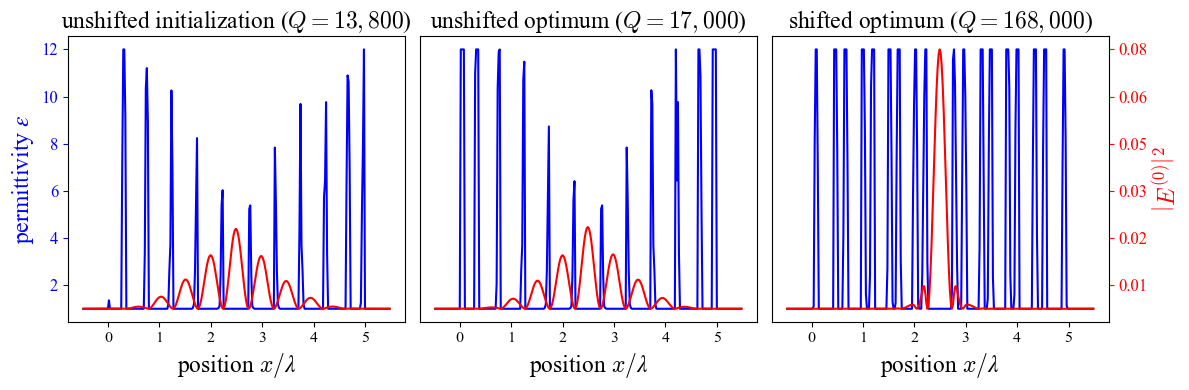

In [159]:
figure(figsize=(12, 4))

subplot(1, 3, 1)
plot(x, ε_init, "b-")
plot(x, (11/true_max)u_init .+ 1, color="red")
title(L"unshifted initialization ($Q = 13,800$)", fontsize=17)
ylabel(L"permittivity $ε$", color="blue", fontsize=17)
gca().tick_params(axis="y", colors="blue")
xlabel(L"position $x / λ$", fontsize=17)


subplot(1, 3, 2)
plot(x, ε_opt, color="blue")
plot(x, (11/true_max)u_opt .+ 1, color="red")
yticks([])
title(L"unshifted optimum ($Q = 17,000$)", fontsize=17)
xlabel(L"position $x / λ$", fontsize=17)

subplot(1, 3, 3)
plot(x, mod_ε_opt, color="blue")
plot(x, (11/true_max)mod_u_opt .+ 1, color="red")
ylabel(L"$\left|E^{(0)}\right|^2$", color="red", fontsize=17)
gca().tick_params(axis="y", colors="red")
gca().yaxis.tick_right()        # move ticks to the right
gca().yaxis.set_label_position("right")  # move label to the right
ytick = gca().get_yticks()
gca().set_yticklabels(string.(round.(true_max .* (ytick .- 1) ./ 11; digits=2)))
title(L"shifted optimum ($Q = 168,000$)", fontsize=17)
xlabel(L"position $x / λ$", fontsize=17)

tight_layout()

In [160]:
function make_smooth_plot(lst)
    current = lst[1]
    output = Float64[current]
    for i in 2:length(lst)
        lst_i = lst[i]
        if lst_i > current
            current = lst_i
        end

        push!(output, current)
    end

    return output
end

make_smooth_plot (generic function with 1 method)

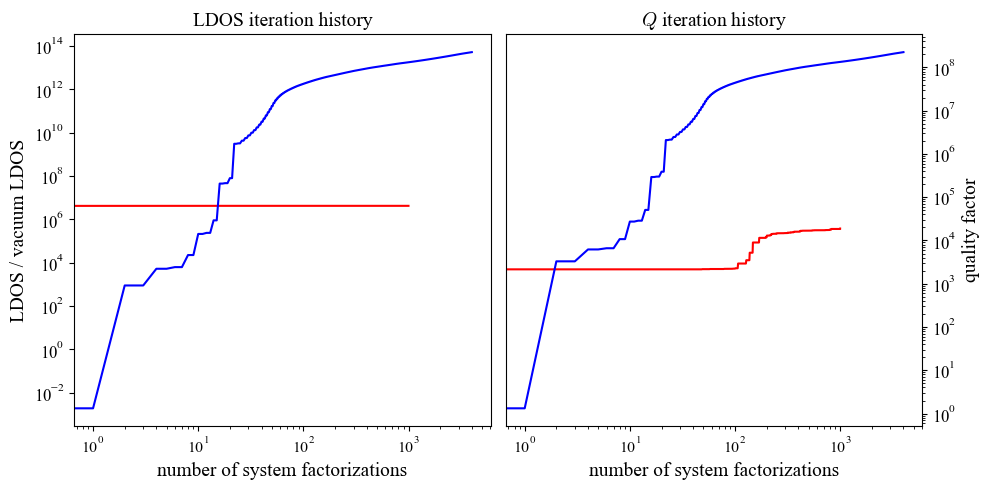

In [161]:
figure(figsize=(10, 5))

subplot(1, 2, 1)
loglog(make_smooth_plot(1 ./ LDOS_vals) / LDOS_vac, color="red")
loglog(vcat(fill.(make_smooth_plot(1 ./ mod_LDOS_vals) / LDOS_vac, 2)...), color="blue")
title("LDOS iteration history", fontsize=14)
ylabel("LDOS / vacuum LDOS", fontsize=14)
xlabel("number of system factorizations", fontsize=14)
# Right plot
subplot(1, 2, 2)
loglog(make_smooth_plot(-real.(omegas) ./ 2imag.(omegas)), color="red")
loglog(vcat(fill.(make_smooth_plot(-real.(mod_omegas) ./ 2imag.(mod_omegas)), 2)...), color="blue")
title(L"$Q$ iteration history", fontsize=14)
ylabel("quality factor", fontsize=14)
gca().yaxis.tick_right()        # move ticks to the right
gca().yaxis.set_label_position("right")  # move label to the right
xlabel("number of system factorizations", fontsize=14)

tight_layout()

In [162]:
function succ_ref(L, L₀, ε_init, ω, b, x₀; resolution=res, max_eval=50, step=1, ftol=1e-4)
    _, ε, LDOS_vals, omegas, x =  inv_LDOS_Optimize(L, ε_init, ω, b; resolution, ftol=0, max_eval, design_width=L₀)
    _, mod_ε_opt, mod_LDOS_vals, mod_omegas, _ = mod_inv_LDOS_Optimize(L, ε, ω, b, x₀; resolution, max_eval, design_width=L₀ + step, ftol)
    append!(LDOS_vals, mod_LDOS_vals)
    append!(omegas, mod_omegas)
    
    n = 2
    while L₀ + (n-1) * step < L
        inv_LDOS, mod_ε_opt, mod_LDOS_vals, mod_omegas, _ = mod_inv_LDOS_Optimize(L, mod_ε_opt, ω, b, x₀; resolution, max_eval, design_width=min(L₀ + n * step, L), ftol)
        append!(LDOS_vals, mod_LDOS_vals)
        append!(omegas, mod_omegas)
        n += 1
    end

    return mod_ε_opt, LDOS_vals, omegas
end

succ_ref (generic function with 1 method)

In [163]:
function succ_ref_no_mod(L, L₀, ε_init, ω, b; resolution=res, max_eval=50, step=1, ftol=1e-4, fixed_inner=false)
    _, ε, LDOS_vals, omegas, x =  inv_LDOS_Optimize(L, ε_init, ω, b; resolution, ftol=0, max_eval, design_width=L₀)
    _, new_ε_opt, new_LDOS_vals, new_omegas, _ = inv_LDOS_Optimize(L, ε, ω, b; resolution, max_eval, design_width=L₀ + step, ftol)
    append!(LDOS_vals, new_LDOS_vals)
    append!(omegas, new_omegas)
    
    n = 2
    while L₀ + (n-1) * step < L
        fixed_width = fixed_inner && n > 2 ? L₀ + (n - 1) * step : 0.0
        LDOS, new_ε_opt, new_LDOS_vals, new_omegas, _ = inv_LDOS_Optimize(L, new_ε_opt, ω, b; resolution, max_eval, design_width=min(L₀ + n * step, L), ftol, fixed_width)
        append!(LDOS_vals, new_LDOS_vals)
        append!(omegas, new_omegas)
        n += 1
    end

    return new_ε_opt, LDOS_vals, omegas
end

succ_ref_no_mod (generic function with 1 method)

In [175]:
step = 0.1

0.1

In [176]:
best_ε_opt, all_LDOS_vals, all_omegas = succ_ref(L, 1, ε, ω, b, b; resolution=res, max_eval=100, step, ftol=0)

numevals = opt.numevals = 100
ω₀_opt = 6.279460528935277 - 0.2621229905994285im
Q_opt = 11.978080431966825
numevals = opt.numevals = 100
ω₀ = 5.474502575312373 - 0.22252541406993015im
Q = 12.300847968744758
numevals = opt.numevals = 100
ω₀ = 5.47450257531236 - 0.222525414069931im
Q = 12.30084796874468
numevals = opt.numevals = 100
ω₀ = 5.7778128795549435 - 0.017357398346154768im
Q = 166.43660427471028
numevals = opt.numevals = 100
ω₀ = 5.7778128795549435 - 0.017357398346154768im
Q = 166.43660427471028
numevals = opt.numevals = 100
ω₀ = 5.7778128795549435 - 0.017357398346154768im
Q = 166.43660427471028
numevals = opt.numevals = 100
ω₀ = 5.7778128795549435 - 0.017357398346154768im
Q = 166.43660427471028
numevals = opt.numevals = 100
ω₀ = 5.7778128795549435 - 0.017357398346154768im
Q = 166.43660427471028
numevals = opt.numevals = 100
ω₀ = 5.7778128795549435 - 0.017357398346154768im
Q = 166.43660427471028
numevals = opt.numevals = 100
ω₀ = 5.962919979930396 - 0.0014953283224865281im
Q = 19

([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0015894422269321887, 0.0015932148999995763, 0.001631207981861311, 0.002200842232487165, 0.0012644143516178726, 0.002446919241034733, 0.005091892732486142, 0.007294122407440161, 0.002302283958535247, 0.013152809414975878  …  8.173620286456106e-11, 8.095365260486807e-11, 8.018765056945257e-11, 7.943769813796663e-11, 7.870331517605459e-11, 7.79840392672642e-11, 7.727942497861142e-11, 7.658904315463923e-11, 7.591248024391434e-11, 7.524933765340558e-11], ComplexF64[5.764179529542722 - 2.1834196863707422im, 5.76293664348448 - 2.1842547601856817im, 5.750951691644981 - 2.192568570412208im, 6.23780285838797 - 1.8704273604675714im, 7.10152023520498 - 0.7403896728676546im, 5.432067897901122 - 0.6308825980932075im, 5.995207476997901 - 0.740060219220591im, 5.95842907258702 - 0.26050783230108326im, 7.292811847423831 - 0.284831083141514im, 6.364165211509483 - 0.37829528159863596im  …  6.151167

In [172]:
new_ε_opt, new_LDOS_vals, new_omegas = succ_ref_no_mod(L, 1, ε, ω, b; resolution=res, max_eval=100, step, ftol=0)

numevals = opt.numevals = 100
ω₀_opt = 6.279460528935277 - 0.2621229905994285im
Q_opt = 11.978080431966825
numevals = opt.numevals = 100
ω₀_opt = 6.283212814940373 - 0.02172753919351946im
Q_opt = 144.59099024003666
numevals = opt.numevals = 100
ω₀_opt = 6.283155176812836 - 0.0017942907985858117im
Q_opt = 1750.8742679182683
numevals = opt.numevals = 100
ω₀_opt = 6.2831910230498 - 0.0017939199241193663im
Q_opt = 1751.246234174642
numevals = opt.numevals = 100
ω₀_opt = 6.283327042318328 - 0.00046561699423015526im
Q_opt = 6747.312834561692
numevals = opt.numevals = 100
ω₀_opt = 6.283222932963528 - 0.00024699189505884774im
Q_opt = 12719.492134481785
numevals = opt.numevals = 100
ω₀_opt = 6.283185315718814 - 0.0002387044343903458im
Q_opt = 13161.015068207991
numevals = opt.numevals = 100
ω₀_opt = 6.283169035024728 - 0.00023169462997729638im
Q_opt = 13559.159820925526
numevals = opt.numevals = 100
ω₀_opt = 6.2831921110915445 - 0.00022772182849548664im
Q_opt = 13795.761593439152


([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0015894422269321887, 0.0015932148999995763, 0.001631207981861311, 0.002200842232487165, 0.0012644143516178726, 0.002446919241034733, 0.005091892732486142, 0.007294122407440161, 0.002302283958535247, 0.013152809414975878  …  19.336926016075555, 18.823533233249055, 19.33829311906518, 19.34734811127137, 19.353319765981883, 19.377848058104338, 19.60714435011411, 0.14785992733049283, 3.542221400037904, 18.960932383037452], ComplexF64[5.764179529542722 - 2.1834196863707422im, 5.76293664348448 - 2.1842547601856817im, 5.750951691644981 - 2.192568570412208im, 6.23780285838797 - 1.8704273604675714im, 7.10152023520498 - 0.7403896728676546im, 5.432067897901122 - 0.6308825980932075im, 5.995207476997901 - 0.740060219220591im, 5.95842907258702 - 0.26050783230108326im, 7.292811847423831 - 0.284831083141514im, 6.364165211509483 - 0.37829528159863596im  …  6.283183127238392 - 0.000231090137329199

In [167]:
# The eigenpair (ω₀, u₀) solves [E⁻¹A(ω) + ω²I]u₀ = ω₀²u₀
E⁻¹ = spdiagm(1 ./ best_ε_opt)
A, x = Maxwell1d(L, best_ε_opt, ω; resolution=res)
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, b, 1, EigSorter(λ -> abs(λ - ω^2); rev = false), Arnoldi()) 
u_sr = abs.(vecs[1]).^2

E⁻¹ = spdiagm(1 ./ new_ε_opt)
A, x = Maxwell1d(L, new_ε_opt, ω; resolution=res)
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, b, 1, EigSorter(λ -> abs(λ - ω^2); rev = false), Arnoldi()) 
u_new = abs.(vecs[1]).^2

E⁻¹ = spdiagm(1 ./ custom_epsilon)
A, x = Maxwell1d(L, custom_epsilon, ω; resolution=res)
vals, vecs, info = eigsolve(z -> E⁻¹ * A * z + ω^2 .* z, b, 1, EigSorter(λ -> abs(λ - ω^2); rev = false), Arnoldi()) 
u_fp = abs.(vecs[1]).^2

new_true_max = maximum(vcat(u_fp, u_sr, u_new))

┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (2.19e-04)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172
┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (2.96e-04)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172
┌ Warning: Arnoldi eigsolve stopped without convergence after 100 iterations:
│ * 0 eigenvalues converged
│ * norm of residuals = (1.60e-05)
│ * number of operations = 1218
└ @ KrylovKit C:\Users\jorge\.julia\packages\KrylovKit\jC5gU\src\eigsolve\arnoldi.jl:172


0.08043238624327063

sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


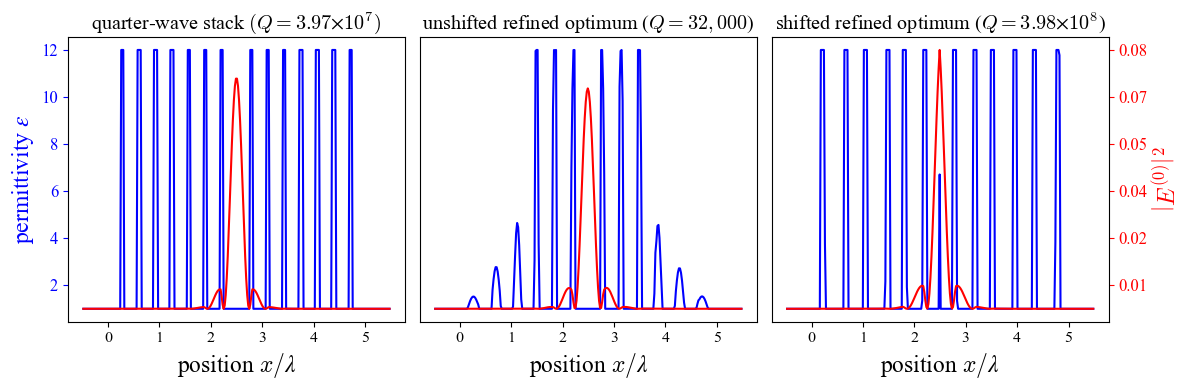

In [168]:
figure(figsize=(12, 4))

subplot(1, 3, 1)
plot(x, custom_epsilon, color="blue")
plot(x, (11/new_true_max)*u_fp .+ 1, color="red")
xlabel(L"position $x / λ$", fontsize=17)
ylabel(L"permittivity $ε$", color="blue", fontsize=17)
gca().tick_params(axis="y", colors="blue")
title(L"quarter-wave stack $(Q = 3.97 × 10^7)$", fontsize=14.5)

subplot(1, 3, 2)
plot(x, new_ε_opt, color="blue")
plot(x, (11/new_true_max)*u_new .+ 1, color="red")
xlabel(L"position $x / λ$", fontsize=17)
yticks([])
title(L"unshifted refined optimum ($Q = 32,000$)", fontsize=14.5)

subplot(1, 3, 3)
plot(x, best_ε_opt, color="blue")
plot(x, (11/new_true_max)*u_sr .+ 1, color="red")
xlabel(L"position $x / λ$", fontsize=17)
ylabel(L"$\left|E^{(0)}\right|^2$", color="red", fontsize=17)
gca().tick_params(axis="y", colors="red")
gca().yaxis.tick_right()        # move ticks to the right
gca().yaxis.set_label_position("right")  # move label to the right
ytick = gca().get_yticks()
gca().set_yticklabels(string.(round.(new_true_max .* (ytick .- 1) ./ 11; digits=2)))
title(L"shifted refined optimum ($Q = 3.98 × 10^8$)", fontsize=14.5)

tight_layout()

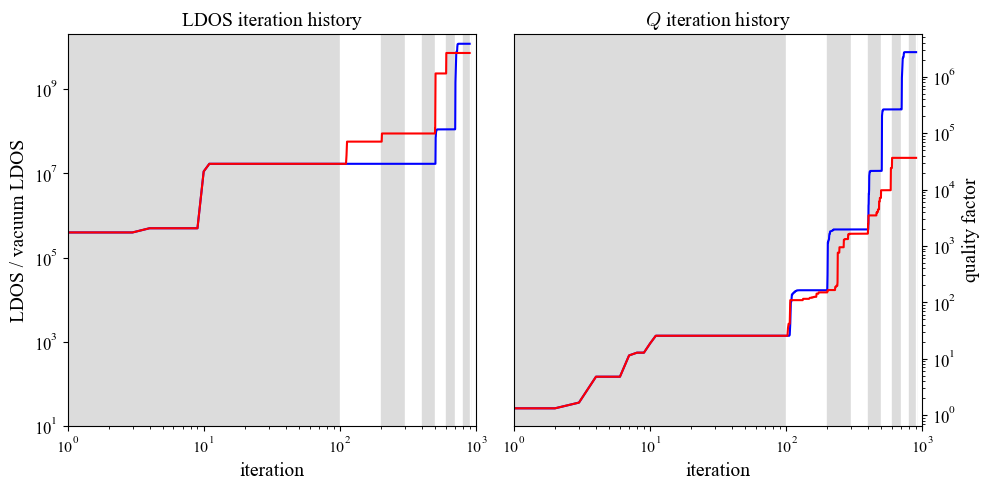

In [169]:
figure(figsize=(10, 5))

subplot(1, 2, 1)
loglog(make_smooth_plot(1 ./ all_LDOS_vals) / LDOS_vac, color="blue")
loglog(make_smooth_plot(1 ./ new_LDOS_vals) / LDOS_vac, color="red")
n_iters = length(all_LDOS_vals)
for i in 0:9
    x_start = i * 100
    x_end = min((i + 1) * 100, n_iters)
    color = (i % 2 == 0) ? "gainsboro" : "white"
    axvspan(x_start, x_end, color=color, zorder=0)
end
title("LDOS iteration history", fontsize=14)
xlabel("iteration", fontsize=14)
ylabel("LDOS / vacuum LDOS", fontsize=14)
gca().set_yticks([10.0^k for k in 1:2:9])
gca().tick_params(which="minor", bottom=true, left=false)
xlim(1, 1000)


# Right plot
subplot(1, 2, 2)
loglog(make_smooth_plot(-real.(all_omegas) ./ 2imag.(all_omegas)), color="blue")
loglog(make_smooth_plot(-real.(new_omegas) ./ 2imag.(new_omegas)), color="red")
n_iters = length(all_LDOS_vals)
for i in 0:9
    x_start = i * 100
    x_end = min((i + 1) * 100, n_iters)
    color = (i % 2 == 0) ? "gainsboro" : "white"
    axvspan(x_start, x_end, color=color, zorder=0)
end
title(L"$Q$ iteration history", fontsize=14)
xlabel("iteration", fontsize=14)
ylabel("quality factor", fontsize=14)
gca().yaxis.tick_right()        # move ticks to the right
gca().yaxis.set_label_position("right")  # move label to the right
xlim(1, 1000)

tight_layout()

In [105]:
function grad_LDOS(L, ε, ω, b; resolution=20)
    A, _ = Maxwell1d(L, ε, ω; resolution)
    v = A \ vec(b)
    w = conj.(v)
    return -2ω^2 * imag.(w.^2) / (-imag(v' * b))^3
end

grad_LDOS (generic function with 1 method)

In [106]:
function grad_mod_LDOS(L, ε, ω, b, x₀; resolution=20)
    E = spdiagm(ε)
    E⁻¹ = spdiagm(1 ./ ε)
    A, _ = Maxwell1d(L, ε, ω; resolution)
    D² = A + ω^2 .* spdiagm(ε)
    C = E⁻¹ * A
    LU = lu(C)

    vals, vecs, _ = eigsolve(z -> LU \ z, x₀, 1, :LM, Arnoldi())
    vals = sqrt.(1 ./ vals .+ ω^2)
    ω₀, u₀ = vals[1], vecs[1]
    A₀ = D² - real(ω₀)^2 .* E
    v = A₀ \ vec(b)
    w = conj.(v)  

    ∂LDOS_∂ε = -imag.(real(ω₀)^2 .* w.^2)
    ∂LDOS_∂ω = -imag(2real(ω₀) .* sum(w.^2 .* conj.(ε)))
    ∂ω_∂ε = -ω₀ .* u₀.^2 ./ 2sum(u₀.^2 .* ε)

    return -2(∂LDOS_∂ε .+  ∂LDOS_∂ω .* real.(∂ω_∂ε)) / (-imag(v' * b))^3
end

grad_mod_LDOS (generic function with 1 method)

In [107]:
function Hess_LDOS(L, ε, ω, b; resolution=20)
    n = length(ε)
    Jac = []
    free_idx = findall(x -> x != 1 && x != 12, ε)

    for j in free_idx
        e_j = zeros(n)
        e_j[j] = 1

        f = h -> grad_LDOS(L, ε + h * e_j, ω, b; resolution)
        grad_dir = extrapolate_fdm(central_fdm(10, 1), f, 0)[1]
        push!(Jac, grad_dir[free_idx])
    end

    return hcat(Jac...)
end

Hess_LDOS (generic function with 1 method)

In [108]:
function Hess_mod_LDOS(L, ε, ω, b, x₀; resolution=20)
    n = length(ε)
    Jac = []
    free_idx = findall(x -> x != 1 && x != 12, ε)


    for j in free_idx
        e_j = zeros(n)
        e_j[j] = 1

        f = h -> grad_mod_LDOS(L, ε + h * e_j, ω, b, x₀; resolution)
        grad_dir = extrapolate_fdm(central_fdm(10, 1), f, 0)[1]
        push!(Jac, grad_dir[free_idx])
    end

    return hcat(Jac...)
end

Hess_mod_LDOS (generic function with 1 method)

In [180]:
A, x = Maxwell1d(L, mod_ε_opt, ω; resolution=res)
ω₀ = sqrt(Arnoldi_eig(A, vec(mod_ε_opt), ω, vec(b))[1])

6.5823148473781306 - 1.458220740368241e-8im

In [181]:
Hess1 = Hess_LDOS(L, mod_ε_opt, real(ω₀), b; resolution=res);

In [182]:
Hess2 = Hess_mod_LDOS(L, mod_ε_opt, real(ω₀), b, b; resolution=res);

In [183]:
@show norm(Hess1 - hermitianpart(Hess1)) / norm(Hess1)
SVD1 = svdvals(Hess1)
κ_1 = maximum(SVD1) / minimum(SVD1)

norm(Hess1 - hermitianpart(Hess1)) / norm(Hess1) = 0.7070841352667027


8.406356437875453e62

In [184]:
@show norm(Hess2 - hermitianpart(Hess2)) / norm(Hess2)
SVD2 = svdvals(Hess2)
κ_2 = maximum(SVD2) / minimum(SVD2)

norm(Hess2 - hermitianpart(Hess2)) / norm(Hess2) = 9.80200655458859e-11


3391.6069400947495

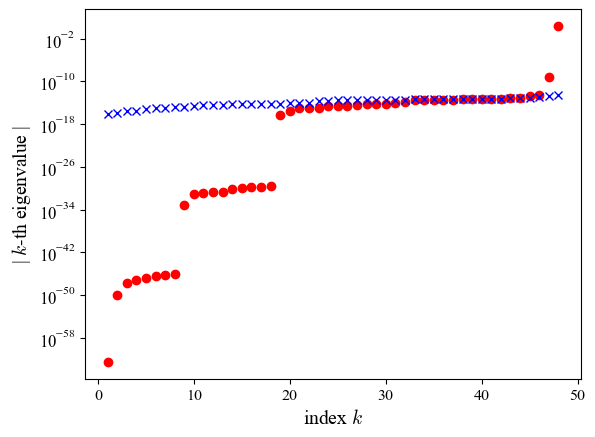

PyObject Text(33.00000000000001, 0.5, '| $k$-th eigenvalue |')

In [185]:
semilogy(1:length(SVD1), reverse(SVD1), "ro")
semilogy(1:length(SVD2), reverse(SVD2), "bx")
xlabel(L"index $k$", fontsize=14)
ylabel(L"| $k$-th eigenvalue |", fontsize=14)

In [115]:
u = eigvecs(Hess1)[:,1]
A, _ = Maxwell1d(L, ε_init, real(ω₀); resolution=res)
v = Eigengradient(A, ε_init, real(ω₀), b)[2]
free_idx = findall(x -> 1 < x < 12, ε_init)
v = normalize(real(v[free_idx]))

@show acosd(u' * v), acosd(-u' * v)
u' * v

(acosd(u' * v), acosd(-(u') * v)) = (179.99997036286157, 2.9637138425220448e-5)


-0.9999999999998662